## Import Dependencies

In [81]:
import cv2
import numpy as np
import csv
import glob
import pandas as pd
import os
from openpyxl import load_workbook
from openpyxl.chart import ScatterChart, Reference, Series
import datetime
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
from scipy.stats import norm
import io

## Set up

Enter/change any of the following values
Pick the path of the images which are going to be analyzed. 
Enter in what number in the sequence the initial image is located in (how many images the program should skip). 
Enter the initial coordinates for the sunspot in question.

Creates a cicular mask around the sun, shifts the coordiante axis to be centered upon the center of the sun.

In [82]:
# For example 'Further_Analysis/SOHO_2025-06-08_2025-06-20/*.jpg'
Image_Path = 'Further_Analysis/Images/SOHO_2024-01-01_2024-12-31/*.jpg'


# The name of the sunspot being analyzed
Sunspot_Name = '3591'
#Date_Range = 'SOHO_2025-03-31_2025-04-06'

# The first image with the sunspot visible
first_image_number = 577 +14
last_image_number = first_image_number + 80
number_of_rows = last_image_number - first_image_number

# Initial coordinates of the sunspot in the first image (replace with your values)
Sunspot_initial_x = 98
Sunspot_initial_y = 383

# Sun parameters
sun_center_x, sun_center_y = 256, 256
sun_radius = 234

csv_file = f'Further_Analysis/Sunspots_Data/Sunspot_{Sunspot_Name}.csv'
excel_file = f'Further_Analysis/Sunspots_Data/Sunspot_{Sunspot_Name}.xlsx'

horizons_file = '/Users/mehtabsingh/Documents/Python/Bridge_Project/Further_Analysis/horizons_results.txt' # Or horizons_results.txt

with open(horizons_file, 'r') as f:
    all_lines = f.readlines()

# Find the start and end of the data block
start_line_index = -1
end_line_index = -1

for i, line in enumerate(all_lines):
    if '$$SOE' in line:
        start_line_index = i + 1 # Data starts on the *next* line
    elif '$$EOE' in line:
        end_line_index = i # Data ends on *this* line
        break

# Extract just the data lines
data_block = "".join(all_lines[start_line_index:end_line_index])
data_io = io.StringIO(data_block)

# Read this clean data block into pandas
horizons_df = pd.read_csv(
    data_io,
    delim_whitespace=True,
    names=['Date', 'Time', 'ObsSub-LON', 'ObsSub-LAT']
)

# --- 3. PROCESS THE DATA ---
month_map = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}
horizons_df['Date'] = horizons_df['Date'].str.replace(r'([A-Z][a-z]{2})', lambda m: month_map[m.group(1)], regex=True)

# Convert to a real datetime object and set as index
horizons_df['datetime'] = pd.to_datetime(horizons_df['Date'] + ' ' + horizons_df['Time'], format='%Y-%m-%d %H:%M')
horizons_df = horizons_df.set_index('datetime')

# This is our final, clean "lookup table"
b_naught_lookup = horizons_df['ObsSub-LAT']

print("HORIZONS data loaded and indexed successfully.")

#print(b_naught_lookup)

HORIZONS data loaded and indexed successfully.


/var/folders/8m/x8f071113t3d7gdwzp03c1f40000gn/T/ipykernel_43451/1164589510.py:46: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  horizons_df = pd.read_csv(


Loads the images, creates a cicular mask around the sun

In [83]:
image_files = sorted(glob.glob(Image_Path))

# Turning into coordinates based off center of sun
initial_x_center = Sunspot_initial_x - sun_center_x
initial_y_center = Sunspot_initial_y - sun_center_x
initial_d = np.sqrt(initial_x_center **2 + initial_y_center **2)
initial_d_err = np.sqrt(0.5**2 + 0.5**2)

# Load the first image to get dimensions
first_image = cv2.imread(image_files[first_image_number], cv2.IMREAD_GRAYSCALE)
height, width = first_image.shape

# making a circular mask
mask_y, mask_x = np.ogrid[:height, :width]
mask_distance = np.sqrt((mask_x - sun_center_x)**2 + (mask_y - sun_center_y)**2)
black_mask = mask_distance < sun_radius
black_mask = (black_mask).astype(np.uint8)



## Sunspot Detection

Using the initial sunspot coordinates, the code creates a detection box of size $r$. The darkest pixel inside that box will be the center of the sunspot in that frame. The coordinate is stored before continuing to the next frame. The detection box is redrawn around the new coordinate, and repeated. This procress is repeated for all the frames in the folder.

Note the creation of the circular mask earlier. Without that mask the detection box could include pixels outside the Sun and have erronously detected the space around the sun to contain the sunspot center.

The coordinate of the sunspot is stored as the length of a vector $| \vec d |$ which points from the center of the Sun to the sunspot.

In [84]:
# The search radius for the detection box
r = 10

# List to store positions
positions = []

# Record initial position
t = 0
image_time = 1.5 *t
#positions.append((image_time, os.path.basename(image_files[first_image_number]), Sunspot_initial_x, Sunspot_initial_y, initial_d, initial_d_err, sun_radius, 1))
current_position = (Sunspot_initial_x, Sunspot_initial_y)
previous_movement = (0, 0)

#####
first_img_name = os.path.basename(image_files[first_image_number])

# Extract the timestamp part (e.g., "20250921_1930")
parts = first_img_name.split('_')
first_timestamp_str = parts[0] + '_' + parts[1]

# Convert the string into a true datetime object
t_0 = datetime.datetime.strptime(first_timestamp_str, "%Y%m%d_%H%M")
#####


# Process each  image
for i in range(first_image_number, last_image_number):
    
    
    image = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)


    #######
    current_filename = os.path.basename(image_files[i])
    
    # 2. Extract the timestamp string
    parts = current_filename.split('_')
    current_timestamp_str = parts[0] + '_' + parts[1]
    
    # 3. Convert to a datetime object
    current_time_obj = datetime.datetime.strptime(current_timestamp_str, "%Y%m%d_%H%M")
    
    # 4. Calculate the time difference from the start
    time_delta = current_time_obj - t_0
    
    # 5. Convert that difference into total hours
    image_time = time_delta.total_seconds() / 3600.0

    #####

    
   
    ret, thresh = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    sun_center_x = int(x)
    sun_center_y = int(y)
    R_sun_t = radius

    B_0_degrees = b_naught_lookup.asof(current_time_obj)
    B_0_pixels = R_sun_t * np.sin(np.deg2rad(B_0_degrees))
    
    # Calculate search center
    search_center_x = current_position[0] + previous_movement[0]
    search_center_y = current_position[1] + previous_movement[1]
    
    # Define the detection box boundaries
    x_min = max(0, search_center_x - r)
    x_max = min(width, search_center_x + r + 1)
    y_min = max(0, search_center_y - r)
    y_max = min(height, search_center_y + r + 1)
    
    # Extract sub-image
    sub_image = image[y_min:y_max, x_min:x_max]
    black_sub_mask = black_mask[y_min:y_max, x_min:x_max]
    
    # Find the minimum intensity pixel
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(sub_image, mask=black_sub_mask)
    min_x, min_y = min_loc
    
    # Convert to global coordinates
    global_x = x_min + min_x
    global_y = y_min + min_y
    
    global_x_center = global_x - sun_center_x
    global_y_center = global_y - sun_center_y
    d_vector = np.sqrt(global_x_center **2 + global_y_center **2) #get d vector from python, no need for excel
    d_err = np.sqrt(0.5**2 + 0.5**2)



    

    positions.append((
        image_time,     # 0. Time (hours)
        os.path.basename(image_files[i]),       # 1. Filename
        global_x,       # 2. Spot X
        global_y,       # 3. Spot Y
        d_vector,       # 4. Measured Distance (pixels)
        d_err,          # 5. Error in Distance (pixels)
        R_sun_t,        # 6. Sun Radius (pixels)
        B_0_pixels      # 7. SOHO Latitude (pixels)
    ))
    
    # Calculate movement
    movement = (global_x - current_position[0], global_y - current_position[1])
    
    # Update current position and previous movement
    current_position = (global_x, global_y)
    previous_movement = movement

print("done")
#print(positions)


done


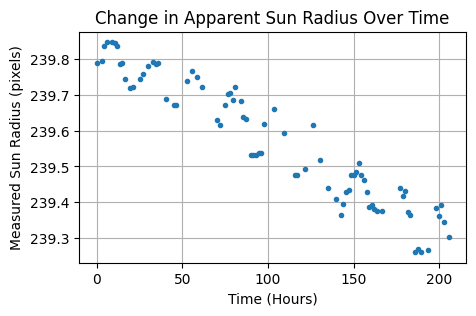

In [85]:
radius_columns = ['time', 'filename', 'x', 'y', 'd_vector', 'd_err', 'R_sun', 'B_0']

# 2. Convert your list of tuples into a DataFrame
radius_df = pd.DataFrame(positions, columns=radius_columns)

# 3. Create the plot
plt.figure(figsize=(5, 3))

# Plot time vs. radius. Using '.' gives a scatter plot.
plt.plot(radius_df['time'], radius_df['R_sun'], marker='.', linestyle='None')

plt.xlabel('Time (Hours)')
plt.ylabel('Measured Sun Radius (pixels)')
plt.title('Change in Apparent Sun Radius Over Time')
plt.grid(True) # Adds a grid to make it easier to see changes
plt.show()

### Visualize Sunspot Motion

The distance of the sunspot from the center of the Sun $| \vec d|$ is plotted over time to show its motion across the face of the Sun.

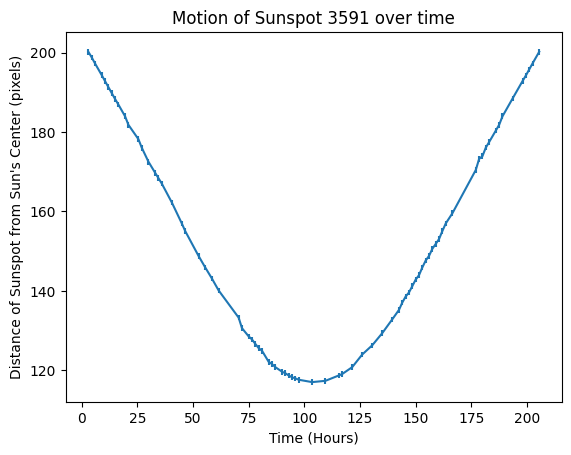

In [86]:

# Write positions to CSV
with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Hours', 'Filename', 'x', 'y', 'd', 'd_err', 'R_sun', 'B_0'])
    for hours, Filename, x, y, d, d_err, R_sun, B_0 in positions:
        writer.writerow([hours, Filename, x, y, d, d_err, R_sun, B_0])

#convert to excel file bcs easier to use/manipulate/plot


# Load the CSV file from above
df = pd.read_csv(csv_file)

#convert to excel
df.to_excel(excel_file, index=False)

#change the width
wb = load_workbook(excel_file)
ws = wb.active
ws.column_dimensions['B'].width = 25.5  # Set width in Excel units

wb.save(excel_file)
df = pd.read_excel(excel_file)

plt.figure()
plt.errorbar(df.iloc[1:number_of_rows, 0], df.iloc[1:number_of_rows, 4], yerr=df.iloc[1:number_of_rows,5])
plt.xlabel('Time (Hours)')
plt.ylabel('Distance of Sunspot from Sun\'s Center (pixels)')
plt.title('Motion of Sunspot '+ Sunspot_Name+ ' over time')
plt.show()

## Data Extraction

### Finding Latitude and $d_\text{min}$
The angle of latitude of the sunspot is given by
$$ \theta _{\text{latitude}} = \sin ^{-1} \left( \frac{\delta}{R_\text{Sun}} \right), $$
where $\delta$ is found as the minimum value of $|\vec d|$ from the graph above.

The model for the apparent motion of a sunspot crossing the Sun, taking into account foreshortening is
$$d_m(\omega, t) = \sqrt{\left(R_\text{Sun}^2 - \delta^2\right) \sin ^2 (\omega [t- t_0]) + \delta^2}.$$
At $t=t_0$, $d_m = \delta$.

In [87]:
delta = df.iloc[2:number_of_rows,4].min()
latitude = np.rad2deg(np.arcsin(delta/sun_radius))
latitude_radius = sun_radius * np.cos(latitude)
delta_idx = df.iloc[2:number_of_rows, 4].idxmin()
t_0 = df.iloc[delta_idx, 0]

print("d_min = ", delta)
print("The sunspot has a latitude of \u00B1", latitude, " degrees", sep="")
print("The radius of the circle of latitude is ", latitude_radius, " pixels", sep="")


d_min =  117.0170927685353
The sunspot has a latitude of ±30.004832803422623 degrees
The radius of the circle of latitude is 37.21175466156281 pixels


### Determining the value of $\omega$

This function finds the initial value of $\omega$ by first calculating the value of 
$$f(\omega) = \int _0 ^T |d_m(\omega, t) - d(t)| \text{ d}t,$$
$\forall \,\omega \in \{ \omega_\text{min},\omega_\text{max}\}$. The value of $\omega$ which leads to the smallest value of this function is taken to be the best value of the angular velocity.


Best omega = 0.009121194313313314, Sum: 60.6945858229402
Period:  28.702314500309075


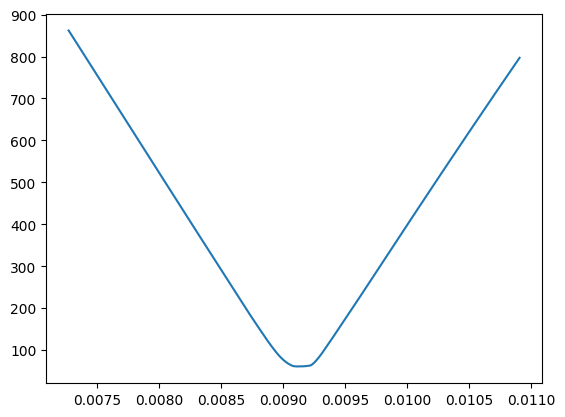

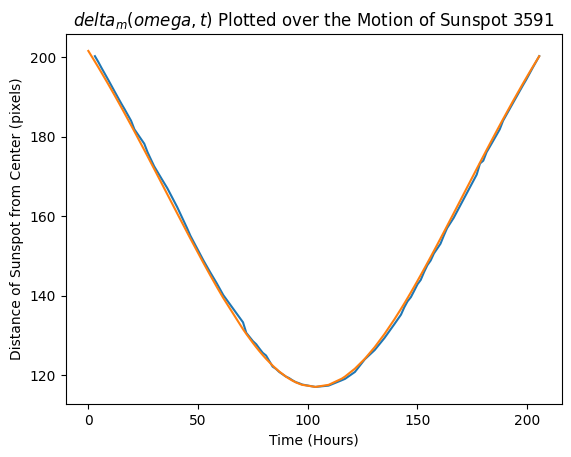

In [88]:
min_omega = 0.010908308 #int(input("minimum omega (rad/hr) = "))
max_omega = 0.007272205 #int(input("max omega (rad/hr) = "))
num_iterations = 1000 #int(input("how many variations to check? "))
iterations = (max_omega - min_omega)/num_iterations  
    

t = df.iloc[:number_of_rows, 0]
d = df.iloc[:number_of_rows, 4]
d_err = df.iloc[:number_of_rows, 5]
R_sun = df.iloc[:number_of_rows, 6]
B_0_values = df.iloc[:number_of_rows, 7]

#print(t_0)
#print(type(t))

def f(t, omega):
    return np.sqrt((sun_radius **2 - delta **2)*(np.sin(omega*(t-t_0)))**2 + delta **2)

omega_values = np.linspace(min_omega, max_omega, num_iterations)

#result_df = pd.DataFrame({'t': t})
#for omega in omega_values:
    #result_df[omega] = f(t, omega)



data = {'t': t}
for omega in omega_values:
    data[omega] = f(t, omega)  # Compute f(t, omega) and store in dictionary
result_df = pd.DataFrame(data) # Create result_df in one step



#print(result_df.head())

def dif(col_index):
    return np.abs(result_df.iloc[:, col_index + 1] - d)



#difference_df = pd.DataFrame({'ω': omega_values})

#for i, omega in enumerate(omega_values):
   # difference_df[omega] = dif(i)

data2 = {omega: dif(i) for i, omega in enumerate(omega_values)}
difference_df = pd.DataFrame(data2)



#print(difference_df.head())

# the value of the best omega is the value of omega which yields the lowest summed differences
summed = difference_df.sum(axis=0)
sum_matrix = pd.DataFrame([summed])
best_omega = sum_matrix.iloc[0, :].idxmin()
print(f"Best omega = {best_omega}, Sum: {sum_matrix[best_omega].iloc[0]}")
Period = (np.pi)/(12*best_omega)
print(f"Period:  {Period}")
#print(sum_matrix)

#print(sum_matrix.idxmin())
#print(sum_matrix.min())


plt.figure()
plt.plot(sum_matrix.columns, sum_matrix.iloc[0, :])
plt.show()

plt.figure()
plt.plot(df.iloc[1:number_of_rows, 0], df.iloc[1:number_of_rows, 4])
plt.plot(result_df.iloc[:, 0], result_df.loc[:, best_omega])
plt.xlabel('Time (Hours)')
plt.ylabel('Distance of Sunspot from Center (pixels)')
plt.title(r'$delta _m(omega, t)$ Plotted over the Motion of Sunspot ' + Sunspot_Name)
plt.show()


# End timer
#end_time = time.perf_counter()
#elapsed_time = end_time - start_time
#print(f"Execution time: {elapsed_time:.2f} seconds")

## $\chi ^2$ Analysis

Now that we have a rough value for $\omega$ and the period, a full $\chi ^2$ anaylsis will give us a better value, as well as the error on that estimate.

Looking at the model equation,
$$d_m(\omega, t) = \sqrt{\left(R_\text{Sun}^2 - \delta^2\right) \sin ^2 (\omega [t- t_0]) + \delta^2},$$
New model equation is
$$d_{m}(\omega,t) = \sqrt{ (R_{\text{Sun}}(t)^2- \delta ^2) \sin^2(\omega [t-t_{0}])+ (\delta - B_{0}(t))^2 }$$
the parameters that need to be varied are $\delta, \omega,$ and $t_0$.

Set up values

In [89]:
#From Above, just for reference
#t = df.iloc[:number_of_rows, 0]
#d = df.iloc[:number_of_rows, 4]
initial_values = np.array([delta, best_omega, t_0]) # Initial guess for fit parameters
degrees_of_freedom = t.size - initial_values.size

def model_function(t, *params):
    return np.sqrt((R_sun **2 - params[0] **2)*(np.sin(params[1]*(t-params[2])))**2 + (params[0]-B_0_values) **2)


def chi_squared(model_params, model, x_data, y_data, y_err):
    return np.sum(((y_data - model(x_data, *model_params))/y_err)**2) # Note the `*model_params' here!
print(degrees_of_freedom)

77


## Do the actual $\chi ^2$ fit

In [94]:
lower_bounds = [110, 0.0, 0.0]
upper_bounds = [ 200, np.inf,  np.inf]

bounds = (lower_bounds, upper_bounds)
popt, cov = scipy.optimize.curve_fit(model_function, # function to fit
                                     t, # x data
                                     d, # y data
                                     sigma=d_err, # array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial_values, # starting point for fit
                                     check_finite=True,
                                     bounds = bounds) # raise ValueError if NaN encountered (don't allow errors to pass)

print('Optimised parameters = ', popt, '\n')
print('Covariance matrix = \n', cov)

Optimised parameters =  [1.10000000e+02 6.61106265e-03 1.05071031e+02] 

Covariance matrix = 
 [[ 1.84701923e-02 -1.47894786e-06  1.15486396e-03]
 [-1.47894786e-06  2.56791621e-10 -1.84930687e-07]
 [ 1.15486396e-03 -1.84930687e-07  1.82030869e-02]]


Visual check to see if fit works

chi^2_min = 26451.762582143754
reduced chi^2 = 343.5293841836851
P(chi^2_min, DoF) = 0.0
DOF = 77
best fit $\delta$ = 110.00000000000001
best fit $\omega$ = 0.0066110626452557135
best fit $t_0$ = 105.07103081727516
Period = 39.60019770604112
$\delta$ err = 0.1359050857060544
$\omega$ err = 1.602471906101235e-05
$\t_0$ err = 0.13491881580293635


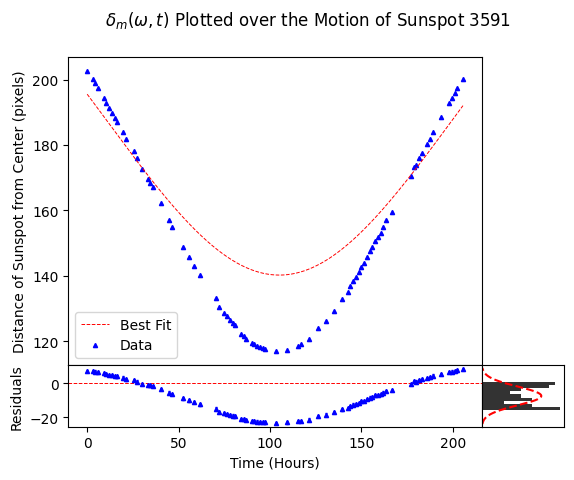

In [95]:
fig, axs = plt.subplots(2, 2,
                        gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [5,1]})

#so they are touching
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
axs[0,0].set_xticklabels([])  
axs[0, 1].axis('off')
axs[1, 1].tick_params(axis='both', which='both', length=0)  
axs[1, 1].set_xticklabels([])  
axs[1, 1].set_yticklabels([])


axs[0,0].errorbar(t,
             d, 
             #yerr = d_err, 
                  fmt = 'b^',
                  capsize =1, markersize =3, elinewidth=1,    
             linestyle='None',
             zorder =1,
             label = 'Data')

B_0_plot_constant = np.mean(B_0_values)
R_sun_constant = np.mean(R_sun)
N_SMOOTH = number_of_rows * 50
t_smooth = np.linspace(np.min(t), np.max(t), N_SMOOTH)

axs[0,0].plot(np.linspace(np.min(t), np.max(t), number_of_rows*50), 
              np.sqrt((R_sun_constant **2 - popt[0] **2)*(np.sin(popt[1]*(t_smooth - popt[2])))**2 + (popt[0]-B_0_plot_constant) **2),
              color = 'r', 
              linewidth = 0.7, 
              linestyle='--',
              zorder =2,
              label = 'Best Fit')

#np.sqrt((R_sun_constant **2 - popt[0] **2)*(np.sin(popt[1]*((np.linspace(np.min(t), np.max(t), number_of_rows*50)-popt[2])))**2 + (popt[0]-B_0_plot_constant) **2)), 



residual = d - model_function(t, *popt)
axs[1,0].errorbar(t, residual, capsize =1, fmt = 'b^', markersize =3, elinewidth=1,yerr=d_err, linestyle = 'None')

axs[1,0].set_xlabel('Time (Hours)') # axis labels and units
axs[0,0].set_ylabel('Distance of Sunspot from Center (pixels)')

axs[1,0].set_ylabel('Residuals')
axs[1,0].axhline(y=0, color='r', linestyle='dashed', linewidth = 0.7)

##### Histogram #####
axs[1,1].hist(residual, bins =9, orientation='horizontal', color='k', alpha=0.8, density=True)

mu = np.mean(residual)
sigma = np.std(residual, ddof=1)
x_normdist = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y_normdist = norm.pdf(x_normdist, mu, sigma)
axs[1,1].plot(y_normdist, x_normdist, color='r', linestyle='dashed')

x_min, x_max = axs[0, 0].get_xlim()
axs[1, 0].set_xlim(x_min, x_max)
###########


axs[0,0].legend()
fig.suptitle(r'$\delta _m(\omega, t)$ Plotted over the Motion of Sunspot ' + Sunspot_Name)
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.path.join
#plt.savefig(os.path.join("Viscocity Lab Saved Figures", f"Viscocity_Lab-Residuals_{timestamp}.pdf"), format="pdf", bbox_inches="tight")



chi_squared_min = chi_squared(popt, model_function, t, d, d_err)
reduced_chi_squared = chi_squared_min/degrees_of_freedom
p_value = scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)
popt_errs = np.sqrt(np.diag(cov))
Period = (np.pi)/(12*popt[1])

print('chi^2_min = {}'.format(chi_squared_min))
print('reduced chi^2 = {}'.format(reduced_chi_squared))
print('P(chi^2_min, DoF) = {}'.format(p_value))
print('DOF = ' + str(degrees_of_freedom))
print(r"best fit $\delta$ = " + str(popt[0]))
print(r"best fit $\omega$ = " + str(popt[1]))
print(r"best fit $t_0$ = " + str(popt[2]))

print(r'Period = ' + str(Period))
#print(r'Viscocity_err = ' + str(Viscocity_err))
print(r"$\delta$ err = " + str(popt_errs[0]))
print(r"$\omega$ err = " + str(popt_errs[1]))
print(r"$\t_0$ err = " + str(popt_errs[2]))

plt.savefig(os.path.join("Further_Analysis/Plots", f"Sunspot_{Sunspot_Name}-Initial_{first_image_number}-Final_{last_image_number}-PValue_{p_value:.3g}.pdf"), format="pdf", bbox_inches="tight")

### Comparing the $\chi ^2$ to the original method

In [92]:
R_sun_avg = df['R_sun'].mean()
new_latitude = np.rad2deg(np.arcsin(popt[0]/R_sun_avg))
latitude_dif = 100*(latitude- new_latitude)/(new_latitude)
omega_dif = 100*((best_omega-popt[1])/popt[1])
t_0_diff = 100*((t_0-popt[2])/(popt[2]))

compare = [
    ["Latitude", latitude, new_latitude , latitude- new_latitude, latitude_dif ],
    ["Omega", best_omega, popt[1], best_omega-popt[1], omega_dif],
    ["t_0", t_0, popt[2], t_0-popt[2], t_0_diff]
]
headers = ["Sunspot {}".format(Sunspot_Name), "Old Values", "Chi Squared Values", "Difference", "Percent Difference"]
compare_df = pd.DataFrame(compare, columns=headers)
print(compare_df)

new_latitude_err = np.abs(np.rad2deg(np.arcsin((popt[0]+popt_errs[0])/R_sun_avg)) - new_latitude)

  Sunspot 3591  Old Values  Chi Squared Values  Difference  Percent Difference
0     Latitude   30.004833           21.318046    8.686787           40.748515
1        Omega    0.009121            0.008101    0.001020           12.594317
2          t_0  103.500000          104.299866   -0.799866           -0.766891


## Write to Final Excel File

In [93]:
Final_excel_file = 'Further_Analysis/New Final Data.xlsx'

new_data_row = [Sunspot_Name, new_latitude, new_latitude_err, popt[1], popt_errs[1], 
                chi_squared_min, reduced_chi_squared, p_value, first_image_number, last_image_number, 
                Sunspot_initial_x, Sunspot_initial_y, r]


file_exists = os.path.exists(Final_excel_file)

wb = load_workbook(Final_excel_file)
ws = wb.active



ws.append(new_data_row)



wb.save(Final_excel_file)
print('Sunspot {} successfully appended to excel file'.format(Sunspot_Name))
'''a = 84.7888872987403
b = 0.114508476806912

print(np.rad2deg(np.arcsin(a/sun_radius)))
print(np.abs(np.rad2deg(np.arcsin((a+b)/sun_radius)) - (np.rad2deg(np.arcsin(a/sun_radius)))))
print(number_of_rows)
print(1009 - 873)
'''

Sunspot 3591 successfully appended to excel file


'a = 84.7888872987403\nb = 0.114508476806912\n\nprint(np.rad2deg(np.arcsin(a/sun_radius)))\nprint(np.abs(np.rad2deg(np.arcsin((a+b)/sun_radius)) - (np.rad2deg(np.arcsin(a/sun_radius)))))\nprint(number_of_rows)\nprint(1009 - 873)\n'